# **DeepLearning Assignment 2 - Problem Statement 8**

### Submitted by Group 118

- Prasanna V 2018AB04621
- Manish Kumar 2018AB04507
- Mayur Hampiholi 2018AB04534

## **Import Libraries/Dataset**

In [ ]:
# Command to print the GPU settings
!nvidia-smi

Sat Jan 16 21:32:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

GPU - Tesla model T4 is assigned with 14Gb of memory is assigned in processor

In [ ]:
# importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, TimeDistributed, Conv2D, MaxPooling2D, ConvLSTM2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import time
from matplotlib import pyplot
%matplotlib inline

# Printing versions and GPU availability
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
GPU is available


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Pre-processing**

- `load_file` loads the file as a numpy array
- `load_group` loads all features and creates a 3D numpy array using `np.dstack`
- `load_dataset_group` loads all input signal data and output data for a single group
- `load_dataset` returns the train and test X and y elements ready for fitting and evaluating and prints their shape


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True, engine='python')
    return dataframe.values

In [ ]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(path):
    # load all train
    trainX, trainy = load_dataset_group('train', path)
    # load all test
    testX, testy = load_dataset_group('test', path)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    # Print the shapes
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)

    return trainX, trainy, testX, testy

In [ ]:
# load data from google drive 
trainX, trainy, testX, testy = load_dataset('/content/drive/MyDrive/HARDataset/')

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [ ]:
# Storing timesteps, features and output variables
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

print(f"n_timesteps = {n_timesteps}, n_features = {n_features}, n_outputs = {n_outputs}")

n_timesteps = 128, n_features = 9, n_outputs = 6


## **Data Visualization**

Plots the line graphs for all features

1. Standing
2. Walking

Using activity labels: 

 - `1 = WALKING`
 - `2 = WALKING_UPSTAIRS`
 - `3 = WALKING_DOWNSTAIRS`
 - `4 = SITTING`
 - `5 = STANDING`
 - `6 = LAYING`


In [ ]:
# plot the data for one subject
def plot_subject(X, y):
    pyplot.figure(figsize=(20, 10))
    # determine the total number of plots
    n, off = X.shape[1], 0
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(pd.Series(X[:, off]))
        pyplot.title('total acc '+ str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(pd.Series(X[:, off]))
        pyplot.title('body acc '+ str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(pd.Series(X[:, off]))
        pyplot.title('body gyro '+ str(i), y=0, loc='left')
        off += 1
    # plot activities
    pyplot.title(return_label(y), y=0)
    pyplot.show()
    return

# Return the label of the class
def return_label(y):
    label_dict = {
        0 :'WALKING',
        1 :'WALKING_UPSTAIRS',
        2 :'WALKING_DOWNSTAIRS',
        3 :'SITTING',
        4 :'STANDING',
        5 :'LAYING'
        }
    return label_dict[np.argmax(y)]

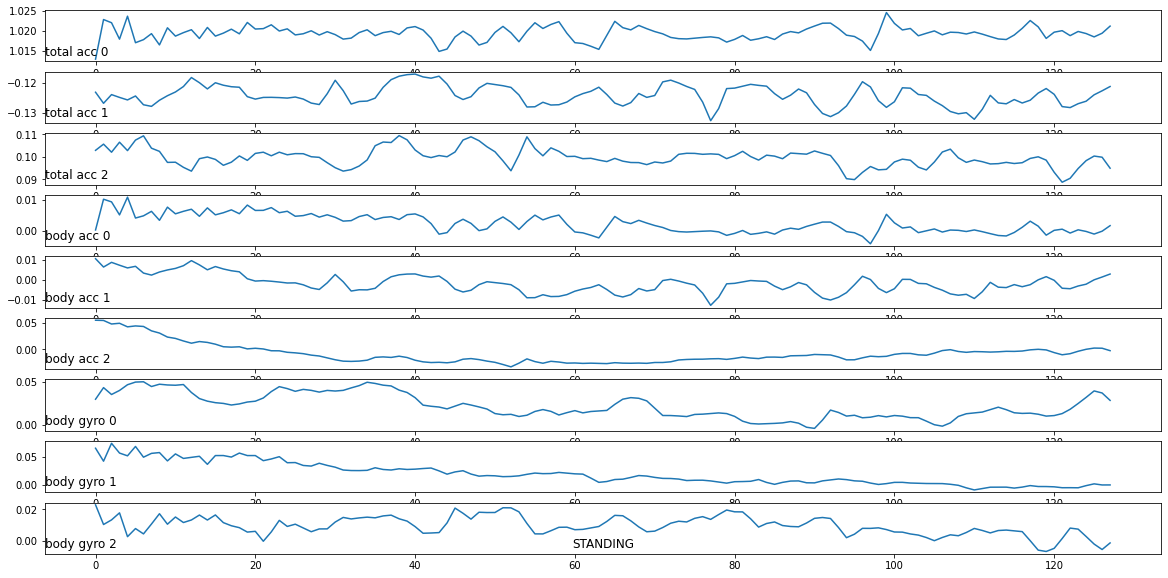

In [ ]:
# Fetch index for standing
standing_index = np.where(np.argmax(trainy, axis=1) == 4)[0][0]

# Plot for standing
plot_subject(trainX[standing_index,:,:], trainy[standing_index, :])

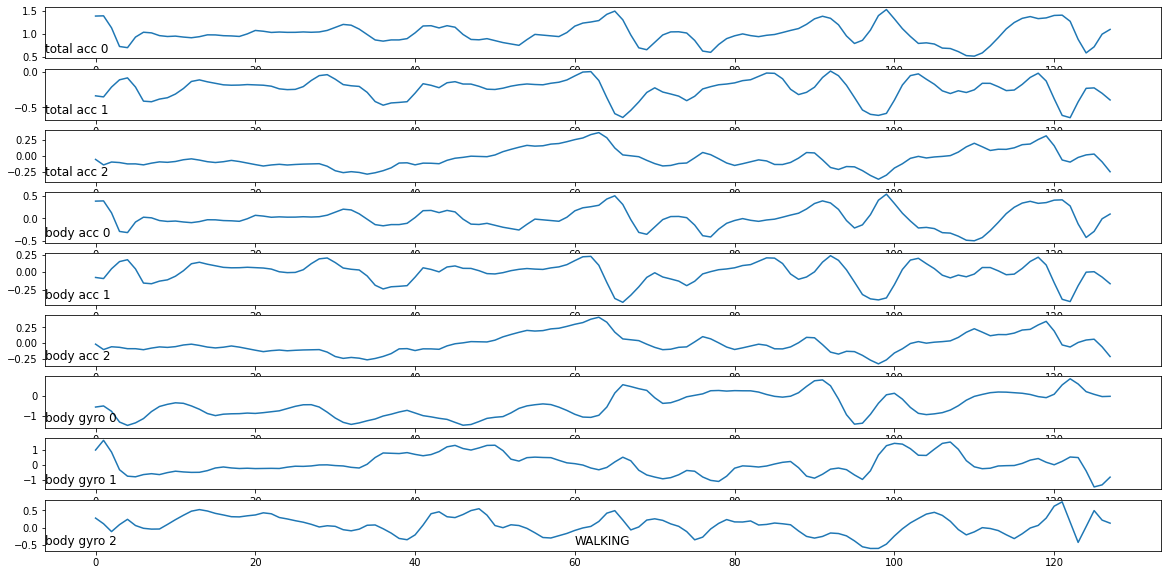

In [ ]:
# Fetch index for walking
standing_index = np.where(np.argmax(trainy, axis=1) == 0)[0][0]

# Plot for walking
plot_subject(trainX[standing_index,:,:], trainy[standing_index, :])

## **Model 1: LSTM**


- After experimentation we've arrived at the following configuration for our hidden layers.
    - Total LSTM layers = 2
    - Total Dense layers = 2
- We've added a relu activation within the hidden layers, softmax activation for the final layer. The reason for this is twofold -
    - RELU typically doesn't suffer from vanish gradient issues
    - SOFTMAX is used to output the final layer activations into multi-class probabilites
- L2 regularisation is added to 2 Dense layers (except the last layer)
- DROPOUT has been added to the model in the early layers of the model with 40% rate to turn neurons on or off
- Model summary is printed within the function


### **Model Building**

In [ ]:
# Build a model given a model name
def LSTM_model(model_name):

    model = Sequential([
      # stacked LSTM layers with 90 input units
      LSTM(90, return_sequences=True, input_shape=(n_timesteps,n_features)),
      LSTM(90),
      Dropout(0.40),
      # dense layer with 120 output units
      Dense(120, activation='relu', kernel_regularizer=l2(0.001)),
      Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
      # softmax layer with 6 output units for target classes
      Dense(n_outputs, activation='softmax'),
      ], model_name)

    # print the model summary
    print(model.summary())

    return model

In [ ]:
model= LSTM_model('Model1')

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 90)           36000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               10920     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                7744      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 120,214
Trainable params: 120,214
Non-trainable params: 0
______________________________________________________

### **Model Compilation**

*   Loss function used for this multi-class prediction problem is the categorical cross-entropy loss.
*   rmsprop optimizer is used here. 
*   With high learning rate, the model will struggle to converge on an optimum. we are setting a low learning rate for the optimizer, which will make it easier to identify overfitting.
*   Lastly, accuracy is used as metric here

In [ ]:
# Function to comile the model given an optimizer
def model_compile(model, optimizer):

    # Compiling the model with the given optimizer
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### **Model Training**


We define two functions here

*   function to help in plotting the loss and accuracy
*   function to train the model

In the model_train function we

*   Use Early Stopping as a means to prevent overfitting
*   Print the total time taken for training
*   Plot the accuracy and loss








    

    


    

    

    


In [ ]:
# Function to plot the loss or accuracy for every epoch
def plot_loss(loss, val_loss, kind):
    plt.figure(figsize=(12,8))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(f'Model {kind}')
    plt.ylabel(f'{kind}')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    return

In [ ]:
#Function to train the model given X and y
def model_train(X, y, model, epochs, batch_size, early_stopping=False):

    start_time = time.time()

    # provide early stopping to prevent overfitting
    if early_stopping:
        # stop training if val_loss does not decrease after 5 epochs
        hist = model.fit(X, y, epochs = epochs, shuffle = True, batch_size = batch_size, validation_split = 0.2, callbacks=[EarlyStopping(patience=5)])
    else:
        hist = model.fit(X, y, epochs = epochs, shuffle = True, batch_size = batch_size, validation_split = 0.2)

    # plot loss and accuracy graphs for every epoch
    plot_loss(hist.history['loss'], hist.history['val_loss'], 'Loss')
    plot_loss(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')

    # Printing the total time taken for training
    print("--- Time taken for training %s seconds ---" % (time.time() - start_time))

    return model

### **Model Evaluation**

In this module, we 

1.   Print the final testing and validation accuracy and loss
2.   Plot the heatmap for the confusion matrix
3.   Generate the classification report

In [ ]:
# Function to evaluate the model performance
def model_evaluation(model, X_train, X_test, y_train, y_test):

    # computing the train and validation loss and accuracy
    train_scores = model.evaluate(X_train, y_train, verbose=1)
    val_scores = model.evaluate(X_test, y_test, verbose=1)

    print(f'Training loss: {train_scores[0]}, Training accuracy: {train_scores[1]}')
    print(f'Validation loss: {val_scores[0]}, Validation accuracy: {val_scores[1]}')

    # predicting on X_test
    y_pred = model.predict(X_test)

    # creating the confusion matrix
    cm = confusion_matrix(np.argmax(y_test , axis=1), np.argmax(y_pred , axis=1))

    # class labels
    label_names = ['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing', 'Laying']

    # plotting the confusion matrix
    fig = plt.figure(figsize=(12,8))
    plt.title('Prediction Count')
    sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='d')
    plt.show()

    # printing the classification report
    print(classification_report(np.argmax(y_test , axis=1), np.argmax(y_pred , axis=1)))

    return

In [ ]:
# Compile the model with RMSprop optimizer and learning rate of 0.001
compiled_model = model_compile(model, RMSprop(0.001))

Epoch 1/30
46/46 [==============================] - 11s 38ms/step - loss: 1.5908 - accuracy: 0.3942 - val_loss: 1.2327 - val_accuracy: 0.5411
Epoch 2/30
46/46 [==============================] - 1s 19ms/step - loss: 1.1048 - accuracy: 0.5921 - val_loss: 1.0762 - val_accuracy: 0.5540
Epoch 3/30
46/46 [==============================] - 1s 18ms/step - loss: 0.8493 - accuracy: 0.6947 - val_loss: 0.9386 - val_accuracy: 0.6866
Epoch 4/30
46/46 [==============================] - 1s 19ms/step - loss: 0.7818 - accuracy: 0.7234 - val_loss: 0.9404 - val_accuracy: 0.6812
Epoch 5/30
46/46 [==============================] - 1s 18ms/step - loss: 0.6601 - accuracy: 0.7680 - val_loss: 0.8723 - val_accuracy: 0.7410
Epoch 6/30
46/46 [==============================] - 1s 19ms/step - loss: 0.6182 - accuracy: 0.7908 - val_loss: 0.8805 - val_accuracy: 0.7396
Epoch 7/30
46/46 [==============================] - 1s 18ms/step - loss: 0.5312 - accuracy: 0.8417 - val_loss: 0.7140 - val_accuracy: 0.8001
Epoch 8/30
4

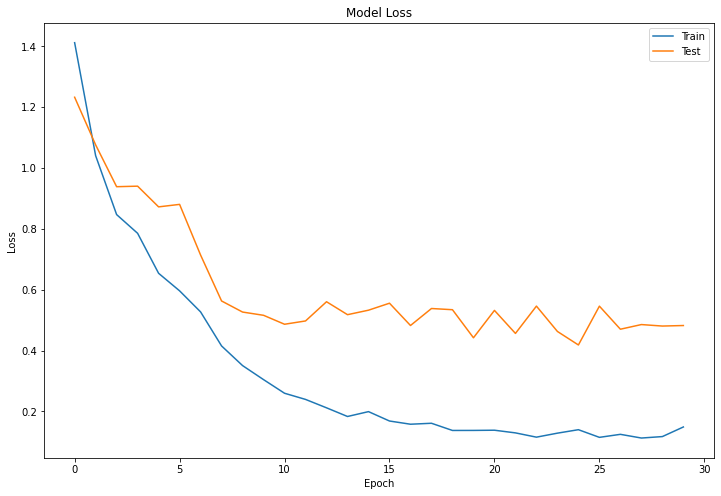

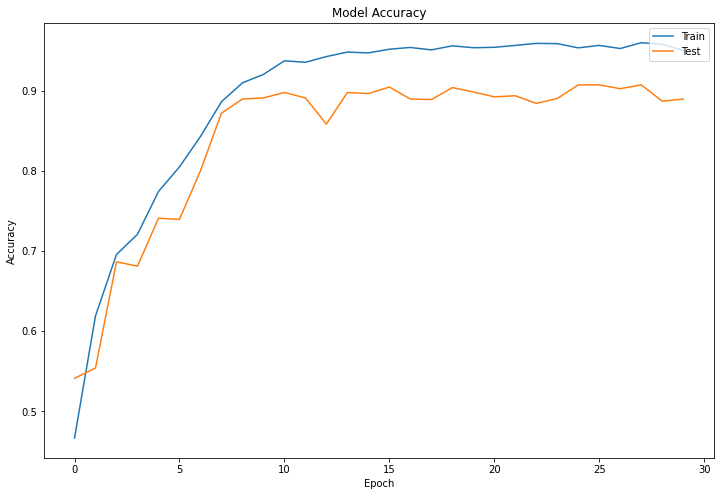

--- Time taken for training 36.32069778442383 seconds ---


In [ ]:
# Train the model
trained_model = model_train(trainX, trainy, model=compiled_model, epochs=30, batch_size=128, early_stopping=False)

93/93 [==============================] - 1s 7ms/step - loss: 0.4479 - accuracy: 0.9046
Training loss: 0.1776249259710312, Training accuracy: 0.9476333260536194
Validation loss: 0.44788703322410583, Validation accuracy: 0.9046487808227539


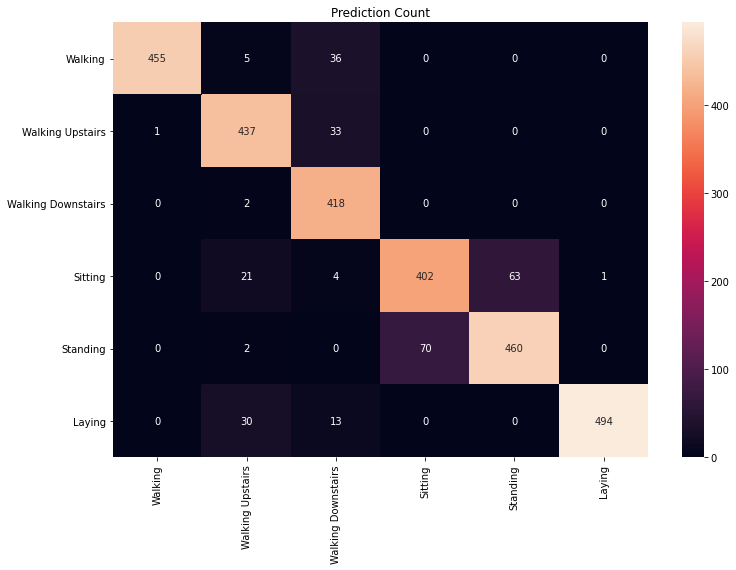

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       496
           1       0.88      0.93      0.90       471
           2       0.83      1.00      0.90       420
           3       0.85      0.82      0.83       491
           4       0.88      0.86      0.87       532
           5       1.00      0.92      0.96       537

    accuracy                           0.90      2947
   macro avg       0.91      0.91      0.90      2947
weighted avg       0.91      0.90      0.91      2947



In [ ]:
# Evaluate the model
model_evaluation(trained_model, trainX, testX, trainy, testy)

## **Model 2: CNN-LSTM**

*   CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.
*   CNN LSTM model will read subsequences of the main sequence in as blocks, extract features from each block, then allow the LSTM to interpret the features extracted from each block.
*   CNN LSTM interprets the output from CNN models
*   It is common to use two consecutive CNN layers followed by dropout and a max pooling layer




    
    
    


In [ ]:
print(n_timesteps, n_features, n_outputs)

128 9 6


In [ ]:
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [ ]:
# Reshape the data to add 1 channel
trainX1 = trainX.reshape(trainX.shape[0], n_timesteps, n_features, 1)
testX1 = testX.reshape(testX.shape[0], n_timesteps, n_features, 1)
trainX1.shape, testX1.shape

((7352, 128, 9, 1), (2947, 128, 9, 1))

### **Model Building**

We've added a relu activation within the hidden layers, softmax activation for the final layer. The reason for this is twofold -

1.   RELU typically doesn't suffer from vanish gradient issues
2.   SOFTMAX is used to output the final layer activations into multi-class probabilites

L2 regularisation is added to Dense layers (except the last layer)

DROPOUT has been added to the model in the early layers of the model with 40% rate to turn neurons on or off

Model summary is printed within the function

In [ ]:
def cnn_lstm_model(model_name):
    model = Sequential([
        TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'),
                        input_shape=(n_timesteps, n_features, 1)),
        TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')),
        TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')),
        TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')),
        TimeDistributed(Dropout(0.3)),
        TimeDistributed(MaxPooling1D(pool_size=2, padding='same')),
        TimeDistributed(Flatten()),
        LSTM(80, return_sequences=True),
        LSTM(80),
        Dropout(0.3),
        Dense(120, kernel_regularizer=l2(0.001), activation='relu'),
        Dense(n_outputs, activation= 'softmax'),
    ], model_name)

    #print the model summary
    print(model.summary())

    return model

In [ ]:
model2= cnn_lstm_model('Model2')

Model: "Model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 128, 7, 128)       512       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 128, 5, 128)       49280     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 128, 3, 256)       98560     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 128, 1, 512)       393728    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 128, 1, 512)       0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 128, 1, 512)       0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 128, 512)          0    

### **Model Compilation**


 

*   Loss function used for this multi-class prediction problem is the categorical cross-entropy loss.
*   Adam optimizer is used here.
*   low learning rate for the optimizer will make it easier to identify overfitting.
*   Lastly, accuracy is used as metric here


In [ ]:
# Compile the model with Adam optimizer and learning rate of 0.0001
compiled_model2 = model_compile(model2, Adam(0.0001))

### **Model Training**

We define two functions here

*   function to help in plotting the loss and accuracy
*   function to train the model

In the model_train function we

*   Use Early Stopping as a means to prevent overfitting
*   Print the total time taken for training
*   Plot the accuracy and loss

Epoch 1/30
46/46 [==============================] - 12s 190ms/step - loss: 1.8494 - accuracy: 0.3768 - val_loss: 1.3738 - val_accuracy: 0.3902
Epoch 2/30
46/46 [==============================] - 8s 165ms/step - loss: 1.1728 - accuracy: 0.4937 - val_loss: 0.8661 - val_accuracy: 0.6798
Epoch 3/30
46/46 [==============================] - 8s 167ms/step - loss: 0.8691 - accuracy: 0.6264 - val_loss: 0.7023 - val_accuracy: 0.7451
Epoch 4/30
46/46 [==============================] - 8s 168ms/step - loss: 0.7301 - accuracy: 0.7288 - val_loss: 0.6515 - val_accuracy: 0.7498
Epoch 5/30
46/46 [==============================] - 8s 168ms/step - loss: 0.6239 - accuracy: 0.7710 - val_loss: 0.6444 - val_accuracy: 0.7593
Epoch 6/30
46/46 [==============================] - 8s 167ms/step - loss: 0.6129 - accuracy: 0.7709 - val_loss: 0.6307 - val_accuracy: 0.7709
Epoch 7/30
46/46 [==============================] - 8s 166ms/step - loss: 0.5484 - accuracy: 0.8028 - val_loss: 0.6335 - val_accuracy: 0.7818
Epoch

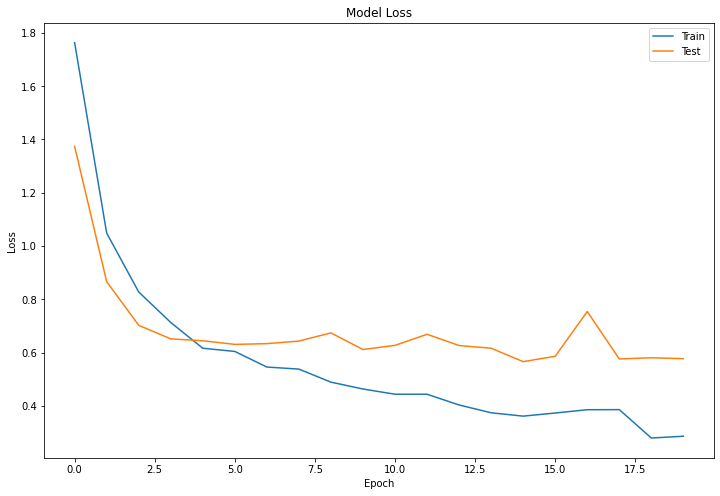

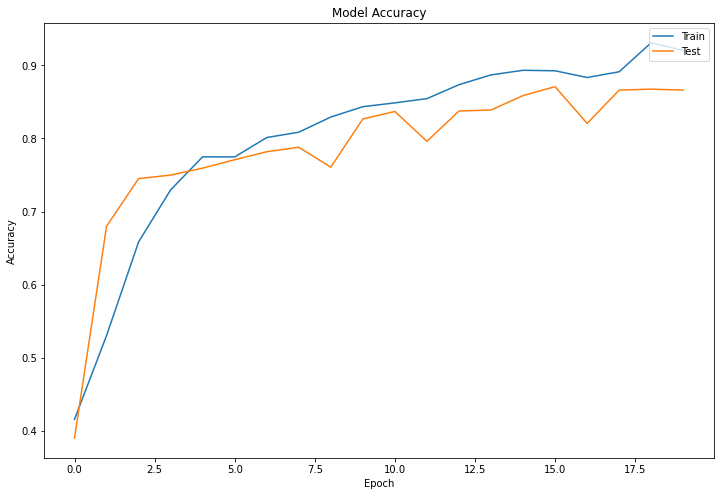

--- Time taken for training 156.96571254730225 seconds ---


In [ ]:
# Train the model
trained_model2 = model_train(trainX1, trainy, model=compiled_model2, epochs=30, batch_size=128, early_stopping=True)

### **Model Evaluation**

93/93 [==============================] - 1s 11ms/step - loss: 0.6178 - accuracy: 0.8500
Training loss: 0.31038209795951843, Training accuracy: 0.921381950378418
Validation loss: 0.6177612543106079, Validation accuracy: 0.8500169515609741


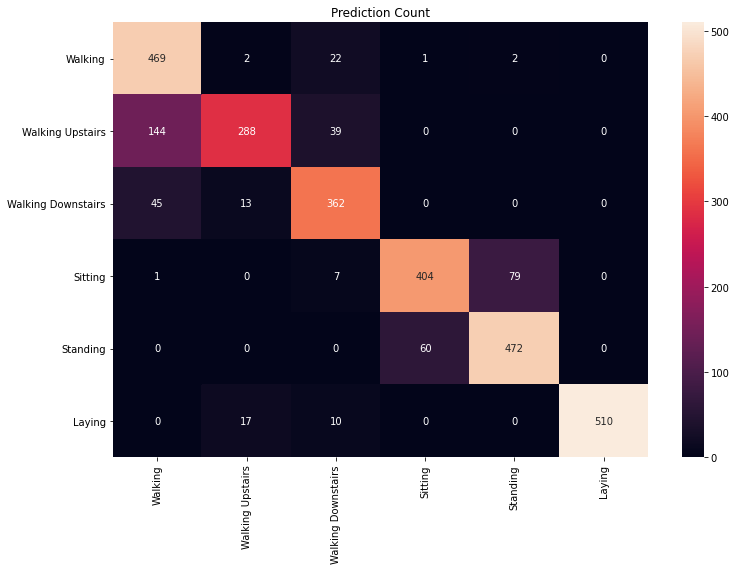

              precision    recall  f1-score   support

           0       0.71      0.95      0.81       496
           1       0.90      0.61      0.73       471
           2       0.82      0.86      0.84       420
           3       0.87      0.82      0.85       491
           4       0.85      0.89      0.87       532
           5       1.00      0.95      0.97       537

    accuracy                           0.85      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.86      0.85      0.85      2947



In [ ]:
# Evaluate the model
model_evaluation(trained_model2, trainX1, testX1, trainy, testy)